#  LTFS Top-up loan Up-sell prediction

A loan is when you receive the money from a financial institution in exchange for future repayment of the principal, plus interest. Financial institutions provide loans to the industries, corporates and individuals. The interest received on these loans is one among the main sources of income for the financial institutions.

A top-up loan, true to its name, is a facility of availing further funds on an existing loan. When you have a loan that has already been disbursed and under repayment and if you need more funds then, you can simply avail additional funding on the same loan thereby minimizing time, effort and cost related to applying again.

LTFS provides it’s loan services to its customers and is interested in selling more of its Top-up loan services to its existing customers so they have decided to identify when to pitch a Top-up during the original loan tenure.  If they correctly identify the most suitable time to offer a top-up, this will ultimately lead to more disbursals and can also help them beat competing offerings from other institutions.

To understand this behaviour, LTFS has provided data for its customers containing the information whether that particular customer took the Top-up service and when he took such Top-up service, represented by the target variable Top-up Month.


You are provided with two types of information: 


1. Customer’s Demographics: The demography table along with the target variable & demographic information contains variables related to Frequency of the loan, Tenure of the loan, Disbursal Amount for a loan & LTV.

2. Bureau data:  Bureau data contains the behavioural and transactional attributes of the customers like current balance, Loan Amount, Overdue etc. for various tradelines of a given customer

As a data scientist, LTFS  has tasked you with building a model given the Top-up loan bucket of 128655 customers along with demographic and bureau data, predict the right bucket/period for 14745 customers in the test data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from xgboost import plot_importance
import datetime
sns.set()
pd.options.display.max_columns =200

In [2]:
train_data_path = Path(Path.cwd(),'Train','train_Data.xlsx')
train_bureau_path = Path(Path.cwd(),'Train','train_bureau.xlsx')

In [3]:
data = pd.read_excel(train_data_path)
data.head(3)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months


In [4]:
bureau = pd.read_excel(train_bureau_path)
bureau.head(3)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN


In [5]:
copy_bureau = bureau.copy()

In [6]:
def dpd_hist(x):
    out = []
    for i in range(0,len(x),3):
        try:
            out.append(float(x[i:i + 3]))
        except:
               pass
    if out:
        ret = np.mean(out)
    else:
        ret = 0
    return ret


def clean_bureau(df):
    clean_col = ['CREDIT-LIMIT/SANC AMT','DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL','OVERDUE-AMT']
    for col in clean_col:
        df[col] = df[col].str.replace(",","").astype(float).fillna(0)
    
    df['WRITE-OFF-AMT'] = df['WRITE-OFF-AMT'].fillna(0)
    df['DISBURSED-DT'] = df['DISBURSED-DT'].fillna(datetime.datetime(1970,1,1))
    df['instal_freq'] = df['INSTALLMENT-AMT'].fillna('0').apply(lambda x: x.split('/')[-1] if '/' in x else x)
    df['instal_amt'] =  df['INSTALLMENT-AMT'].fillna('0').apply(lambda x: x.split('/')[0].replace(',','') if '/' in x else x.replace(',',''))
    df['n_report'] = df['REPORTED DATE - HIST'].fillna('').apply(lambda x: len(x.split(',')))
    df['dpd_hist'] = df['DPD - HIST'].fillna('0').apply(dpd_hist)
    df['curr_bal_hist'] = df['CUR BAL - HIST'].fillna('0').apply(lambda x: np.mean([float(i) if i != '' else 0 for i in x.split(',')]))
    df['amt_overdue_hist'] =  df['AMT OVERDUE - HIST'].fillna('0').apply(lambda x: np.mean([float(i) if i != '' else 0 for i in x.split(',')]))
    df['amt_paid_hist'] = df['AMT PAID - HIST'].fillna('0').apply(lambda x: np.mean([float(i) if i != '' else 0 for i in x.split(',')]))
    df['TENURE'] = df['TENURE'].fillna(0)
    df['INSTALLMENT-FREQUENCY'] = df['INSTALLMENT-FREQUENCY'].fillna('na')
    df['ASSET_CLASS'] = df['ASSET_CLASS'].fillna('na')
    return df

In [7]:
def compute_features(df):
    df['disburse_diff']= (df['AmountFinance'] != df['DisbursalAmount']).astype(int)
    df['per_loan'] = df['DisbursalAmount']/df['AssetCost']
    df['total_int']= (df['Tenure']* df['EMI']) - df['DisbursalAmount']
    df['emi_salary_per'] = df['EMI']/df['MonthlyIncome']
    df['asset_value'] = df['DisbursalAmount']/ df['LTV']
    df['emi_asset'] = df['EMI']/df['asset_value']
    
    
   
    return df

def hot_encode(data,cat_col,enc):
    data = data.copy()

    df= pd.DataFrame(enc.transform(data[cat_col]).toarray(),columns=enc.get_feature_names())
    
    for idx,col in enumerate(cat_col):
        df.columns = df.columns.str.replace(f"x{idx}",col)
    
    for col in df.columns:
        data[col] = df[col]
    
    data.drop(cat_col,axis=1,inplace=True)
    
    return data

In [8]:
def merge_bureau(data,data_bureau,cat_columns,num_col,enc):
    data = data.copy()
    
    pre = pd.DataFrame(enc.transform(data_bureau[cat_columns]).toarray(),columns=enc.get_feature_names())
    for i in range(len(cat_columns)):
            pre.columns = pre.columns.str.replace(f"x{i}",f"pre_{cat_columns[i]}")


    pre['ID'] = data_bureau['ID']
    pre['DISBURSED-DT'] = data_bureau['DISBURSED-DT']
    pre_cat = pre.groupby(['ID','DISBURSED-DT']).mean().groupby(level=0).shift().reset_index().fillna(0)

    pre_num = data_bureau.groupby(['ID','DISBURSED-DT'])[num_col].mean().groupby(level=0).shift().reset_index().fillna(0)
    pre_num = pre_num.add_prefix('pre_')
    pre_num = pre_num.rename({'pre_ID':'ID','pre_DISBURSED-DT':'DISBURSED-DT'},axis=1)

    pre_summary = pd.merge(pre_cat,pre_num,how='outer',on=['ID','DISBURSED-DT'])

    max_dt = pre_summary.groupby(['ID'])['DISBURSED-DT'].max().reset_index()
    post_summary = max_dt.merge(pre_summary,how='left',on=['ID','DISBURSED-DT'])
    post_summary.columns = post_summary.columns.str.replace('pre','post')
    post_summary.drop(['DISBURSED-DT'],axis=1,inplace=True)


    curr_cat = pre.groupby(['ID','DISBURSED-DT']).mean().reset_index().fillna(0)
    curr_cat.columns = curr_cat.columns.str.replace('pre','curr')

    curr_num = data_bureau.groupby(['ID','DISBURSED-DT'])[num_col].mean().reset_index().fillna(0)
    curr_num = curr_num.add_prefix('curr_')
    curr_num = curr_num.rename({'curr_ID':'ID','curr_DISBURSED-DT':'DISBURSED-DT'},axis=1)

    curr_summary = pd.merge(curr_cat,curr_num,how='outer',on=['ID','DISBURSED-DT'])

    data['DISBURSED-DT'] = data['DisbursalDate']
    data = data.merge(pre_summary,how='left',on=['ID','DISBURSED-DT'])
    data=data.merge(curr_summary,how='left',on=['ID','DISBURSED-DT'])
    data=data.merge(post_summary,how='left',on=['ID'])

    return data

In [9]:
bureau = copy_bureau.copy()

In [10]:
cat_columns = ['SELF-INDICATOR','MATCH-TYPE','OWNERSHIP-IND','ACCOUNT-STATUS','INSTALLMENT-FREQUENCY','ASSET_CLASS']

num_col = ['CREDIT-LIMIT/SANC AMT','DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL','OVERDUE-AMT','WRITE-OFF-AMT',
           'instal_amt','n_report','dpd_hist','curr_bal_hist','amt_overdue_hist','amt_paid_hist','TENURE']

bureau = clean_bureau(bureau)
bureau[cat_columns] = bureau[cat_columns].fillna('na')

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(bureau[cat_columns])

merged_data = merge_bureau(data,bureau,cat_columns,num_col,enc)

In [11]:
merged_data.head(3)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,DISBURSED-DT,pre_SELF-INDICATOR_False,pre_SELF-INDICATOR_True,pre_MATCH-TYPE_PRIMARY,pre_MATCH-TYPE_SECONDARY,pre_OWNERSHIP-IND_Guarantor,pre_OWNERSHIP-IND_Individual,pre_OWNERSHIP-IND_Joint,pre_OWNERSHIP-IND_Primary,pre_OWNERSHIP-IND_Supl Card Holder,pre_ACCOUNT-STATUS_Active,pre_ACCOUNT-STATUS_Cancelled,pre_ACCOUNT-STATUS_Closed,pre_ACCOUNT-STATUS_Delinquent,pre_ACCOUNT-STATUS_Restructured,pre_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),pre_ACCOUNT-STATUS_Settled,pre_ACCOUNT-STATUS_Sold/Purchased,pre_ACCOUNT-STATUS_Suit Filed,pre_ACCOUNT-STATUS_WILFUL DEFAULT,pre_ACCOUNT-STATUS_Written Off,pre_INSTALLMENT-FREQUENCY_F01,pre_INSTALLMENT-FREQUENCY_F02,pre_INSTALLMENT-FREQUENCY_F03,pre_INSTALLMENT-FREQUENCY_F04,pre_INSTALLMENT-FREQUENCY_F05,pre_INSTALLMENT-FREQUENCY_F06,pre_INSTALLMENT-FREQUENCY_F07,pre_INSTALLMENT-FREQUENCY_F08,pre_INSTALLMENT-FREQUENCY_F10,pre_INSTALLMENT-FREQUENCY_na,pre_ASSET_CLASS_01,pre_ASSET_CLASS_1,pre_ASSET_CLASS_2,pre_ASSET_CLASS_Doubtful,pre_ASSET_CLASS_Loss,pre_ASSET_CLASS_Special Mention Account,pre_ASSET_CLASS_Standard,pre_ASSET_CLASS_SubStandard,pre_ASSET_CLASS_na,pre_CREDIT-LIMIT/SANC AMT,pre_DISBURSED-AMT/HIGH CREDIT,pre_CURRENT-BAL,pre_OVERDUE-AMT,pre_WRITE-OFF-AMT,pre_n_report,pre_dpd_hist,pre_curr_bal_hist,pre_amt_overdue_hist,pre_amt_paid_hist,pre_TENURE,curr_SELF-INDICATOR_False,curr_SELF-INDICATOR_True,curr_MATCH-TYPE_PRIMARY,curr_MATCH-TYPE_SECONDARY,curr_OWNERSHIP-IND_Guarantor,curr_OWNERSHIP-IND_Individual,curr_OWNERSHIP-IND_Joint,curr_OWNERSHIP-IND_Primary,curr_OWNERSHIP-IND_Supl Card Holder,curr_ACCOUNT-STATUS_Active,curr_ACCOUNT-STATUS_Cancelled,curr_ACCOUNT-STATUS_Closed,curr_ACCOUNT-STATUS_Delinquent,curr_ACCOUNT-STATUS_Restructured,curr_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),curr_ACCOUNT-STATUS_Settled,curr_ACCOUNT-STATUS_Sold/Purchased,curr_ACCOUNT-STATUS_Suit Filed,curr_ACCOUNT-STATUS_WILFUL DEFAULT,curr_ACCOUNT-STATUS_Written Off,curr_INSTALLMENT-FREQUENCY_F01,curr_INSTALLMENT-FREQUENCY_F02,curr_INSTALLMENT-FREQUENCY_F03,curr_INSTALLMENT-FREQUENCY_F04,curr_INSTALLMENT-FREQUENCY_F05,curr_INSTALLMENT-FREQUENCY_F06,curr_INSTALLMENT-FREQUENCY_F07,curr_INSTALLMENT-FREQUENCY_F08,curr_INSTALLMENT-FREQUENCY_F10,curr_INSTALLMENT-FREQUENCY_na,curr_ASSET_CLASS_01,curr_ASSET_CLASS_1,curr_ASSET_CLASS_2,curr_ASSET_CLASS_Doubtful,curr_ASSET_CLASS_Loss,curr_ASSET_CLASS_Special Mention Account,curr_ASSET_CLASS_Standard,curr_ASSET_CLASS_SubStandard,curr_ASSET_CLASS_na,curr_CREDIT-LIMIT/SANC AMT,curr_DISBURSED-AMT/HIGH CREDIT,curr_CURRENT-BAL,curr_OVERDUE-AMT,curr_WRITE-OFF-AMT,curr_n_report,curr_dpd_hist,curr_curr_bal_hist,curr_amt_overdue_hist,curr_amt_paid_hist,curr_TENURE,post_SELF-INDICATOR_False,post_SELF-INDICATOR_True,post_MATCH-TYPE_PRIMARY,post_MATCH-TYPE_SECONDARY,post_OWNERSHIP-IND_Guarantor,post_OWNERSHIP-IND_Individual,post_OWNERSHIP-IND_Joint,post_OWNERSHIP-IND_Primary,post_OWNERSHIP-IND_Supl Card Holder,post_ACCOUNT-STATUS_Active,post_ACCOUNT-STATUS_Cancelled,post_ACCOUNT-STATUS_Closed,post_ACCOUNT-STATUS_Delinquent,post_ACCOUNT-STATUS_Restructured,post_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),post_ACCOUNT-STATUS_Settled,post_ACCOUNT-STATUS_Sold/Purchased,post_ACCOUNT-STATUS_Suit Filed,post_ACCOUNT-STATUS_WILFUL DEFAULT,post_ACCOUNT-STATUS_Written Off,post_INSTALLMENT-FREQUENCY_F01,post_INSTALLMENT-FREQUENCY_F02,post_INSTALLMENT-FREQUENCY_F03,post_INSTALLMENT-FREQUENCY_F04,post_INSTALLMENT-FREQUENCY_F05,post_INSTALLMENT-FREQUENCY_F06,post_INSTALLMENT-FREQUENCY_F07,post_INSTALLMENT-FREQUENCY_F08,post_INSTALLMENT-FREQUENCY_F10,post_INSTALLMENT-FREQUENCY_na,post_ASSET_CLASS_01,post_ASSET_CLASS_1,post_ASSET_CLASS_2,post_ASSET_CLASS_Doubtful,post_ASSET_CLASS_Loss,post_ASSET_CLASS_Special Mention Account,post_ASSET_CLASS_Standard,post_ASSET_C

In [12]:
# np.set_printoptions(threshold=200)

In [13]:
merged_data.shape,data.shape

((128655, 177), (128655, 26))

In [14]:
features = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode','Tenure', 'AssetCost', 'AmountFinance',
            'DisbursalAmount','EMI','LTV', 'SEX', 'AGE','MonthlyIncome', 'State','pre_SELF-INDICATOR_False',
            'pre_SELF-INDICATOR_True', 'pre_MATCH-TYPE_PRIMARY',
               'pre_MATCH-TYPE_SECONDARY', 'pre_OWNERSHIP-IND_Guarantor',
               'pre_OWNERSHIP-IND_Individual', 'pre_OWNERSHIP-IND_Joint',
               'pre_OWNERSHIP-IND_Primary', 'pre_OWNERSHIP-IND_Supl Card Holder',
               'pre_ACCOUNT-STATUS_Active', 'pre_ACCOUNT-STATUS_Cancelled',
               'pre_ACCOUNT-STATUS_Closed', 'pre_ACCOUNT-STATUS_Delinquent',
               'pre_ACCOUNT-STATUS_Restructured',
               'pre_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT)',
               'pre_ACCOUNT-STATUS_Settled', 'pre_ACCOUNT-STATUS_Sold/Purchased',
               'pre_ACCOUNT-STATUS_Suit Filed',
               'pre_ACCOUNT-STATUS_WILFUL DEFAULT',
               'pre_ACCOUNT-STATUS_Written Off', 'pre_INSTALLMENT-FREQUENCY_F01',
               'pre_INSTALLMENT-FREQUENCY_F02', 'pre_INSTALLMENT-FREQUENCY_F03',
               'pre_INSTALLMENT-FREQUENCY_F04', 'pre_INSTALLMENT-FREQUENCY_F05',
               'pre_INSTALLMENT-FREQUENCY_F06', 'pre_INSTALLMENT-FREQUENCY_F07',
               'pre_INSTALLMENT-FREQUENCY_F08', 'pre_INSTALLMENT-FREQUENCY_F10',
               'pre_INSTALLMENT-FREQUENCY_na', 'pre_ASSET_CLASS_01',
               'pre_ASSET_CLASS_1', 'pre_ASSET_CLASS_2',
               'pre_ASSET_CLASS_Doubtful', 'pre_ASSET_CLASS_Loss',
               'pre_ASSET_CLASS_Special Mention Account',
               'pre_ASSET_CLASS_Standard', 'pre_ASSET_CLASS_SubStandard',
               'pre_ASSET_CLASS_na', 'pre_CREDIT-LIMIT/SANC AMT',
               'pre_DISBURSED-AMT/HIGH CREDIT', 'pre_CURRENT-BAL',
               'pre_OVERDUE-AMT', 'pre_WRITE-OFF-AMT', 'pre_n_report',
               'pre_dpd_hist', 'pre_curr_bal_hist', 'pre_amt_overdue_hist',
               'pre_amt_paid_hist', 'pre_TENURE', 'curr_SELF-INDICATOR_False',
               'curr_SELF-INDICATOR_True', 'curr_MATCH-TYPE_PRIMARY',
               'curr_MATCH-TYPE_SECONDARY', 'curr_OWNERSHIP-IND_Guarantor',
               'curr_OWNERSHIP-IND_Individual', 'curr_OWNERSHIP-IND_Joint',
               'curr_OWNERSHIP-IND_Primary',
               'curr_OWNERSHIP-IND_Supl Card Holder',
               'curr_ACCOUNT-STATUS_Active', 'curr_ACCOUNT-STATUS_Cancelled',
               'curr_ACCOUNT-STATUS_Closed', 'curr_ACCOUNT-STATUS_Delinquent',
               'curr_ACCOUNT-STATUS_Restructured',
               'curr_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT)',
               'curr_ACCOUNT-STATUS_Settled',
               'curr_ACCOUNT-STATUS_Sold/Purchased',
               'curr_ACCOUNT-STATUS_Suit Filed',
               'curr_ACCOUNT-STATUS_WILFUL DEFAULT',
               'curr_ACCOUNT-STATUS_Written Off',
               'curr_INSTALLMENT-FREQUENCY_F01', 'curr_INSTALLMENT-FREQUENCY_F02',
               'curr_INSTALLMENT-FREQUENCY_F03', 'curr_INSTALLMENT-FREQUENCY_F04',
               'curr_INSTALLMENT-FREQUENCY_F05', 'curr_INSTALLMENT-FREQUENCY_F06',
               'curr_INSTALLMENT-FREQUENCY_F07', 'curr_INSTALLMENT-FREQUENCY_F08',
               'curr_INSTALLMENT-FREQUENCY_F10', 'curr_INSTALLMENT-FREQUENCY_na',
               'curr_ASSET_CLASS_01', 'curr_ASSET_CLASS_1', 'curr_ASSET_CLASS_2',
               'curr_ASSET_CLASS_Doubtful', 'curr_ASSET_CLASS_Loss',
               'curr_ASSET_CLASS_Special Mention Account',
               'curr_ASSET_CLASS_Standard', 'curr_ASSET_CLASS_SubStandard',
               'curr_ASSET_CLASS_na', 'curr_CREDIT-LIMIT/SANC AMT',
               'curr_DISBURSED-AMT/HIGH CREDIT', 'curr_CURRENT-BAL',
               'curr_OVERDUE-AMT', 'curr_WRITE-OFF-AMT', 'curr_n_report',
               'curr_dpd_hist', 'curr_curr_bal_hist', 'curr_amt_overdue_hist',
               'curr_amt_paid_hist', 'curr_TENURE', 'post_SELF-INDICATOR_False',
               'post_SELF-INDICATOR_True', 'post_MATCH-TYPE_PRIMARY',
               'post_MATCH-TYPE_SECONDARY', 'post_OWNERSHIP-IND_Guarantor',
               'post_OWNERSHIP-IND_Individual', 'post_OWNERSHIP-IND_Joint',
               'post_OWNERSHIP-IND_Primary',
               'post_OWNERSHIP-IND_Supl Card Holder',
               'post_ACCOUNT-STATUS_Active', 'post_ACCOUNT-STATUS_Cancelled',
               'post_ACCOUNT-STATUS_Closed', 'post_ACCOUNT-STATUS_Delinquent',
               'post_ACCOUNT-STATUS_Restructured',
               'post_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT)',
               'post_ACCOUNT-STATUS_Settled',
               'post_ACCOUNT-STATUS_Sold/Purchased',
               'post_ACCOUNT-STATUS_Suit Filed',
               'post_ACCOUNT-STATUS_WILFUL DEFAULT',
               'post_ACCOUNT-STATUS_Written Off',
               'post_INSTALLMENT-FREQUENCY_F01', 'post_INSTALLMENT-FREQUENCY_F02',
               'post_INSTALLMENT-FREQUENCY_F03', 'post_INSTALLMENT-FREQUENCY_F04',
               'post_INSTALLMENT-FREQUENCY_F05', 'post_INSTALLMENT-FREQUENCY_F06',
               'post_INSTALLMENT-FREQUENCY_F07', 'post_INSTALLMENT-FREQUENCY_F08',
               'post_INSTALLMENT-FREQUENCY_F10', 'post_INSTALLMENT-FREQUENCY_na',
               'post_ASSET_CLASS_01', 'post_ASSET_CLASS_1', 'post_ASSET_CLASS_2',
               'post_ASSET_CLASS_Doubtful', 'post_ASSET_CLASS_Loss',
               'post_ASSET_CLASS_Special Mention Account',
               'post_ASSET_CLASS_Standard', 'post_ASSET_CLASS_SubStandard',
               'post_ASSET_CLASS_na', 'post_CREDIT-LIMIT/SANC AMT',
               'post_DISBURSED-AMT/HIGH CREDIT', 'post_CURRENT-BAL',
               'post_OVERDUE-AMT', 'post_WRITE-OFF-AMT', 'post_n_report',
               'post_dpd_hist', 'post_curr_bal_hist', 'post_amt_overdue_hist',
               'post_amt_paid_hist', 'post_TENURE']

x_train = merged_data[features].copy()
x_train.head(3)

,Frequency,InstlmentMode,LoanStatus,PaymentMode,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,SEX,AGE,MonthlyIncome,State,pre_SELF-INDICATOR_False,pre_SELF-INDICATOR_True,pre_MATCH-TYPE_PRIMARY,pre_MATCH-TYPE_SECONDARY,pre_OWNERSHIP-IND_Guarantor,pre_OWNERSHIP-IND_Individual,pre_OWNERSHIP-IND_Joint,pre_OWNERSHIP-IND_Primary,pre_OWNERSHIP-IND_Supl Card Holder,pre_ACCOUNT-STATUS_Active,pre_ACCOUNT-STATUS_Cancelled,pre_ACCOUNT-STATUS_Closed,pre_ACCOUNT-STATUS_Delinquent,pre_ACCOUNT-STATUS_Restructured,pre_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),pre_ACCOUNT-STATUS_Settled,pre_ACCOUNT-STATUS_Sold/Purchased,pre_ACCOUNT-STATUS_Suit Filed,pre_ACCOUNT-STATUS_WILFUL DEFAULT,pre_ACCOUNT-STATUS_Written Off,pre_INSTALLMENT-FREQUENCY_F01,pre_INSTALLMENT-FREQUENCY_F02,pre_INSTALLMENT-FREQUENCY_F03,pre_INSTALLMENT-FREQUENCY_F04,pre_INSTALLMENT-FREQUENCY_F05,pre_INSTALLMENT-FREQUENCY_F06,pre_INSTALLMENT-FREQUENCY_F07,pre_INSTALLMENT-FREQUENCY_F08,pre_INSTALLMENT-FREQUENCY_F10,pre_INSTALLMENT-FREQUENCY_na,pre_ASSET_CLASS_01,pre_ASSET_CLASS_1,pre_ASSET_CLASS_2,pre_ASSET_CLASS_Doubtful,pre_ASSET_CLASS_Loss,pre_ASSET_CLASS_Special Mention Account,pre_ASSET_CLASS_Standard,pre_ASSET_CLASS_SubStandard,pre_ASSET_CLASS_na,pre_CREDIT-LIMIT/SANC AMT,pre_DISBURSED-AMT/HIGH CREDIT,pre_CURRENT-BAL,pre_OVERDUE-AMT,pre_WRITE-OFF-AMT,pre_n_report,pre_dpd_hist,pre_curr_bal_hist,pre_amt_overdue_hist,pre_amt_paid_hist,pre_TENURE,curr_SELF-INDICATOR_False,curr_SELF-INDICATOR_True,curr_MATCH-TYPE_PRIMARY,curr_MATCH-TYPE_SECONDARY,curr_OWNERSHIP-IND_Guarantor,curr_OWNERSHIP-IND_Individual,curr_OWNERSHIP-IND_Joint,curr_OWNERSHIP-IND_Primary,curr_OWNERSHIP-IND_Supl Card Holder,curr_ACCOUNT-STATUS_Active,curr_ACCOUNT-STATUS_Cancelled,curr_ACCOUNT-STATUS_Closed,curr_ACCOUNT-STATUS_Delinquent,curr_ACCOUNT-STATUS_Restructured,curr_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),curr_ACCOUNT-STATUS_Settled,curr_ACCOUNT-STATUS_Sold/Purchased,curr_ACCOUNT-STATUS_Suit Filed,curr_ACCOUNT-STATUS_WILFUL DEFAULT,curr_ACCOUNT-STATUS_Written Off,curr_INSTALLMENT-FREQUENCY_F01,curr_INSTALLMENT-FREQUENCY_F02,curr_INSTALLMENT-FREQUENCY_F03,curr_INSTALLMENT-FREQUENCY_F04,curr_INSTALLMENT-FREQUENCY_F05,curr_INSTALLMENT-FREQUENCY_F06,curr_INSTALLMENT-FREQUENCY_F07,curr_INSTALLMENT-FREQUENCY_F08,curr_INSTALLMENT-FREQUENCY_F10,curr_INSTALLMENT-FREQUENCY_na,curr_ASSET_CLASS_01,curr_ASSET_CLASS_1,curr_ASSET_CLASS_2,curr_ASSET_CLASS_Doubtful,curr_ASSET_CLASS_Loss,curr_ASSET_CLASS_Special Mention Account,curr_ASSET_CLASS_Standard,curr_ASSET_CLASS_SubStandard,curr_ASSET_CLASS_na,curr_CREDIT-LIMIT/SANC AMT,curr_DISBURSED-AMT/HIGH CREDIT,curr_CURRENT-BAL,curr_OVERDUE-AMT,curr_WRITE-OFF-AMT,curr_n_report,curr_dpd_hist,curr_curr_bal_hist,curr_amt_overdue_hist,curr_amt_paid_hist,curr_TENURE,post_SELF-INDICATOR_False,post_SELF-INDICATOR_True,post_MATCH-TYPE_PRIMARY,post_MATCH-TYPE_SECONDARY,post_OWNERSHIP-IND_Guarantor,post_OWNERSHIP-IND_Individual,post_OWNERSHIP-IND_Joint,post_OWNERSHIP-IND_Primary,post_OWNERSHIP-IND_Supl Card Holder,post_ACCOUNT-STATUS_Active,post_ACCOUNT-STATUS_Cancelled,post_ACCOUNT-STATUS_Closed,post_ACCOUNT-STATUS_Delinquent,post_ACCOUNT-STATUS_Restructured,post_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),post_ACCOUNT-STATUS_Settled,post_ACCOUNT-STATUS_Sold/Purchased,post_ACCOUNT-STATUS_Suit Filed,post_ACCOUNT-STATUS_WILFUL DEFAULT,post_ACCOUNT-STATUS_Written Off,post_INSTALLMENT-FREQUENCY_F01,post_INSTALLMENT-FREQUENCY_F02,post_INSTALLMENT-FREQUENCY_F03,post_INSTALLMENT-FREQUENCY_F04,post_INSTALLMENT-FREQUENCY_F05,post_INSTALLMENT-FREQUENCY_F06,post_INSTALLMENT-FREQUENCY_F07,post_INSTALLMENT-FREQUENCY_F08,post_INSTALLMENT-FREQUENCY_F10,post_INSTALLMENT-FREQUENCY_na,post_ASSET_CLASS_01,post_ASSET_CLASS_1,post_ASSET_CLASS_2,post_ASSET_CLASS_Doubtful,post_ASSET_CLASS_Loss,post_ASSET_CLASS_Special Mention Account,post_ASSET_CLASS_Standard,post_ASSET_CLASS_SubStandard,post_ASSET_CLASS_na,post_CREDIT-LIMIT/SANC AMT,post_DISBURSED-AMT/HIGH CREDIT,post_CURRENT-BAL,post_OVERDUE-A

In [15]:
y_train = merged_data['Top-up Month']

categorical_var = ['Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode','SEX', 'State']

x_train[categorical_var] = x_train[categorical_var].fillna('na')
x_train = compute_features(x_train)
x_train_copy = x_train.copy()



cat_enc = OneHotEncoder(handle_unknown='ignore')
cat_enc.fit(x_train[categorical_var])

x_train = hot_encode(x_train,categorical_var,cat_enc)

x_train.fillna(0,inplace=True)
x_train.sample(3)

,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,pre_SELF-INDICATOR_False,pre_SELF-INDICATOR_True,pre_MATCH-TYPE_PRIMARY,pre_MATCH-TYPE_SECONDARY,pre_OWNERSHIP-IND_Guarantor,pre_OWNERSHIP-IND_Individual,pre_OWNERSHIP-IND_Joint,pre_OWNERSHIP-IND_Primary,pre_OWNERSHIP-IND_Supl Card Holder,pre_ACCOUNT-STATUS_Active,pre_ACCOUNT-STATUS_Cancelled,pre_ACCOUNT-STATUS_Closed,pre_ACCOUNT-STATUS_Delinquent,pre_ACCOUNT-STATUS_Restructured,pre_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),pre_ACCOUNT-STATUS_Settled,pre_ACCOUNT-STATUS_Sold/Purchased,pre_ACCOUNT-STATUS_Suit Filed,pre_ACCOUNT-STATUS_WILFUL DEFAULT,pre_ACCOUNT-STATUS_Written Off,pre_INSTALLMENT-FREQUENCY_F01,pre_INSTALLMENT-FREQUENCY_F02,pre_INSTALLMENT-FREQUENCY_F03,pre_INSTALLMENT-FREQUENCY_F04,pre_INSTALLMENT-FREQUENCY_F05,pre_INSTALLMENT-FREQUENCY_F06,pre_INSTALLMENT-FREQUENCY_F07,pre_INSTALLMENT-FREQUENCY_F08,pre_INSTALLMENT-FREQUENCY_F10,pre_INSTALLMENT-FREQUENCY_na,pre_ASSET_CLASS_01,pre_ASSET_CLASS_1,pre_ASSET_CLASS_2,pre_ASSET_CLASS_Doubtful,pre_ASSET_CLASS_Loss,pre_ASSET_CLASS_Special Mention Account,pre_ASSET_CLASS_Standard,pre_ASSET_CLASS_SubStandard,pre_ASSET_CLASS_na,pre_CREDIT-LIMIT/SANC AMT,pre_DISBURSED-AMT/HIGH CREDIT,pre_CURRENT-BAL,pre_OVERDUE-AMT,pre_WRITE-OFF-AMT,pre_n_report,pre_dpd_hist,pre_curr_bal_hist,pre_amt_overdue_hist,pre_amt_paid_hist,pre_TENURE,curr_SELF-INDICATOR_False,curr_SELF-INDICATOR_True,curr_MATCH-TYPE_PRIMARY,curr_MATCH-TYPE_SECONDARY,curr_OWNERSHIP-IND_Guarantor,curr_OWNERSHIP-IND_Individual,curr_OWNERSHIP-IND_Joint,curr_OWNERSHIP-IND_Primary,curr_OWNERSHIP-IND_Supl Card Holder,curr_ACCOUNT-STATUS_Active,curr_ACCOUNT-STATUS_Cancelled,curr_ACCOUNT-STATUS_Closed,curr_ACCOUNT-STATUS_Delinquent,curr_ACCOUNT-STATUS_Restructured,curr_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),curr_ACCOUNT-STATUS_Settled,curr_ACCOUNT-STATUS_Sold/Purchased,curr_ACCOUNT-STATUS_Suit Filed,curr_ACCOUNT-STATUS_WILFUL DEFAULT,curr_ACCOUNT-STATUS_Written Off,curr_INSTALLMENT-FREQUENCY_F01,curr_INSTALLMENT-FREQUENCY_F02,curr_INSTALLMENT-FREQUENCY_F03,curr_INSTALLMENT-FREQUENCY_F04,curr_INSTALLMENT-FREQUENCY_F05,curr_INSTALLMENT-FREQUENCY_F06,curr_INSTALLMENT-FREQUENCY_F07,curr_INSTALLMENT-FREQUENCY_F08,curr_INSTALLMENT-FREQUENCY_F10,curr_INSTALLMENT-FREQUENCY_na,curr_ASSET_CLASS_01,curr_ASSET_CLASS_1,curr_ASSET_CLASS_2,curr_ASSET_CLASS_Doubtful,curr_ASSET_CLASS_Loss,curr_ASSET_CLASS_Special Mention Account,curr_ASSET_CLASS_Standard,curr_ASSET_CLASS_SubStandard,curr_ASSET_CLASS_na,curr_CREDIT-LIMIT/SANC AMT,curr_DISBURSED-AMT/HIGH CREDIT,curr_CURRENT-BAL,...,post_SELF-INDICATOR_False,post_SELF-INDICATOR_True,post_MATCH-TYPE_PRIMARY,post_MATCH-TYPE_SECONDARY,post_OWNERSHIP-IND_Guarantor,post_OWNERSHIP-IND_Individual,post_OWNERSHIP-IND_Joint,post_OWNERSHIP-IND_Primary,post_OWNERSHIP-IND_Supl Card Holder,post_ACCOUNT-STATUS_Active,post_ACCOUNT-STATUS_Cancelled,post_ACCOUNT-STATUS_Closed,post_ACCOUNT-STATUS_Delinquent,post_ACCOUNT-STATUS_Restructured,post_ACCOUNT-STATUS_SUIT FILED (WILFUL DEFAULT),post_ACCOUNT-STATUS_Settled,post_ACCOUNT-STATUS_Sold/Purchased,post_ACCOUNT-STATUS_Suit Filed,post_ACCOUNT-STATUS_WILFUL DEFAULT,post_ACCOUNT-STATUS_Written Off,post_INSTALLMENT-FREQUENCY_F01,post_INSTALLMENT-FREQUENCY_F02,post_INSTALLMENT-FREQUENCY_F03,post_INSTALLMENT-FREQUENCY_F04,post_INSTALLMENT-FREQUENCY_F05,post_INSTALLMENT-FREQUENCY_F06,post_INSTALLMENT-FREQUENCY_F07,post_INSTALLMENT-FREQUENCY_F08,post_INSTALLMENT-FREQUENCY_F10,post_INSTALLMENT-FREQUENCY_na,post_ASSET_CLASS_01,post_ASSET_CLASS_1,post_ASSET_CLASS_2,post_ASSET_CLASS_Doubtful,post_ASSET_CLASS_Loss,post_ASSET_CLASS_Special Mention Account,post_ASSET_CLASS_Standard,post_ASSET_CLASS_SubStandard,post_ASSET_CLASS_na,post_CREDIT-LIMIT/SANC AMT,post_DISBURSED-AMT/HIGH CREDIT,post_CURRENT-BAL,post_OVERDUE-AMT,post_WRITE-OFF-AMT,post_n_report,post_dpd_hist,post_curr_bal_hist,post_amt_overdue_hist,post_amt_paid_hist,post_TENURE,disburse_diff,per_loan,total_int,emi_salary_per,asset_value,emi_ass

In [16]:
log_col = ['AssetCost', 'AmountFinance',
           'DisbursalAmount','MonthlyIncome','EMI','pre_CREDIT-LIMIT/SANC AMT','pre_DISBURSED-AMT/HIGH CREDIT',
           'pre_CURRENT-BAL','pre_OVERDUE-AMT','pre_WRITE-OFF-AMT','pre_curr_bal_hist','pre_amt_overdue_hist',
           'pre_amt_paid_hist','curr_CURRENT-BAL','curr_OVERDUE-AMT','curr_WRITE-OFF-AMT','curr_curr_bal_hist',
           'curr_amt_overdue_hist','curr_amt_paid_hist','post_CURRENT-BAL','post_OVERDUE-AMT','post_WRITE-OFF-AMT',
           'post_curr_bal_hist',
           'post_amt_overdue_hist','post_amt_paid_hist','disburse_diff','total_int',
           'emi_salary_per','asset_value','emi_asset']

x_train[log_col] = np.log(x_train[log_col]+1)
x_train[log_col] = x_train[log_col].replace([-np.inf,np.inf,np.nan],[0,0,0])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [17]:
k_train = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
wt = dict(zip(np.unique(y_train), k_train))
w_array = y_train.map(wt)
w_array = w_array.values

In [18]:
xgb = XGBClassifier(learning_rate = 0.05,n_estimators=100,max_depth=5,min_child_weight=1,
                     gamma=0.05,subsample=1, colsample_bytree=1,objective= 'multi:softmax',nthread=4,seed=27)
xgb.fit(x_train,y_train, eval_metric='auc', sample_weight=w_array)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
train_predict = xgb.predict(x_train)
train_predict = np.squeeze(train_predict)
print(classification_report(y_train, train_predict))

                   precision    recall  f1-score   support

      > 48 Months       0.20      0.77      0.32      8366
     12-18 Months       0.10      0.63      0.17      1034
     18-24 Months       0.14      0.63      0.23      2368
     24-30 Months       0.19      0.56      0.29      3492
     30-36 Months       0.17      0.46      0.24      3062
     36-48 Months       0.14      0.46      0.21      3656
No Top-up Service       0.97      0.44      0.61    106677

         accuracy                           0.47    128655
        macro avg       0.27      0.56      0.30    128655
     weighted avg       0.84      0.47      0.55    128655



In [20]:
test_data_path = Path(Path.cwd(),'Test','test_Data.xlsx')
test_bureau_path = Path(Path.cwd(),'Test','test_bureau.xlsx')

test_data = pd.read_excel(test_data_path)
test_bureau = pd.read_excel(test_bureau_path)

test_bureau_copy = test_bureau.copy()

In [21]:
test_bureau = clean_bureau(test_bureau)

test_bureau[cat_columns] = test_bureau[cat_columns].fillna('na')


test_merged_data = merge_bureau(test_data,test_bureau,cat_columns,num_col,enc)

x_test = test_merged_data[features].copy()
x_test[categorical_var] = x_test[categorical_var].fillna('na')

x_test = compute_features(x_test)
x_test = hot_encode(x_test,categorical_var,cat_enc)

x_test.fillna(0,inplace=True)

x_test[log_col] = np.log(x_test[log_col]+1)
x_test[log_col] = x_test[log_col].replace([-np.inf,np.inf,np.nan],[0,0,0])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [22]:
x_test.shape,test_data.shape

((14745, 208), (14745, 25))

In [23]:
test_predict = xgb.predict(x_test)
test_predict = np.squeeze(test_predict)
test_data['Top-up Month'] = test_predict
test_data[['ID','Top-up Month']].to_csv('submit_3.csv',index=False)

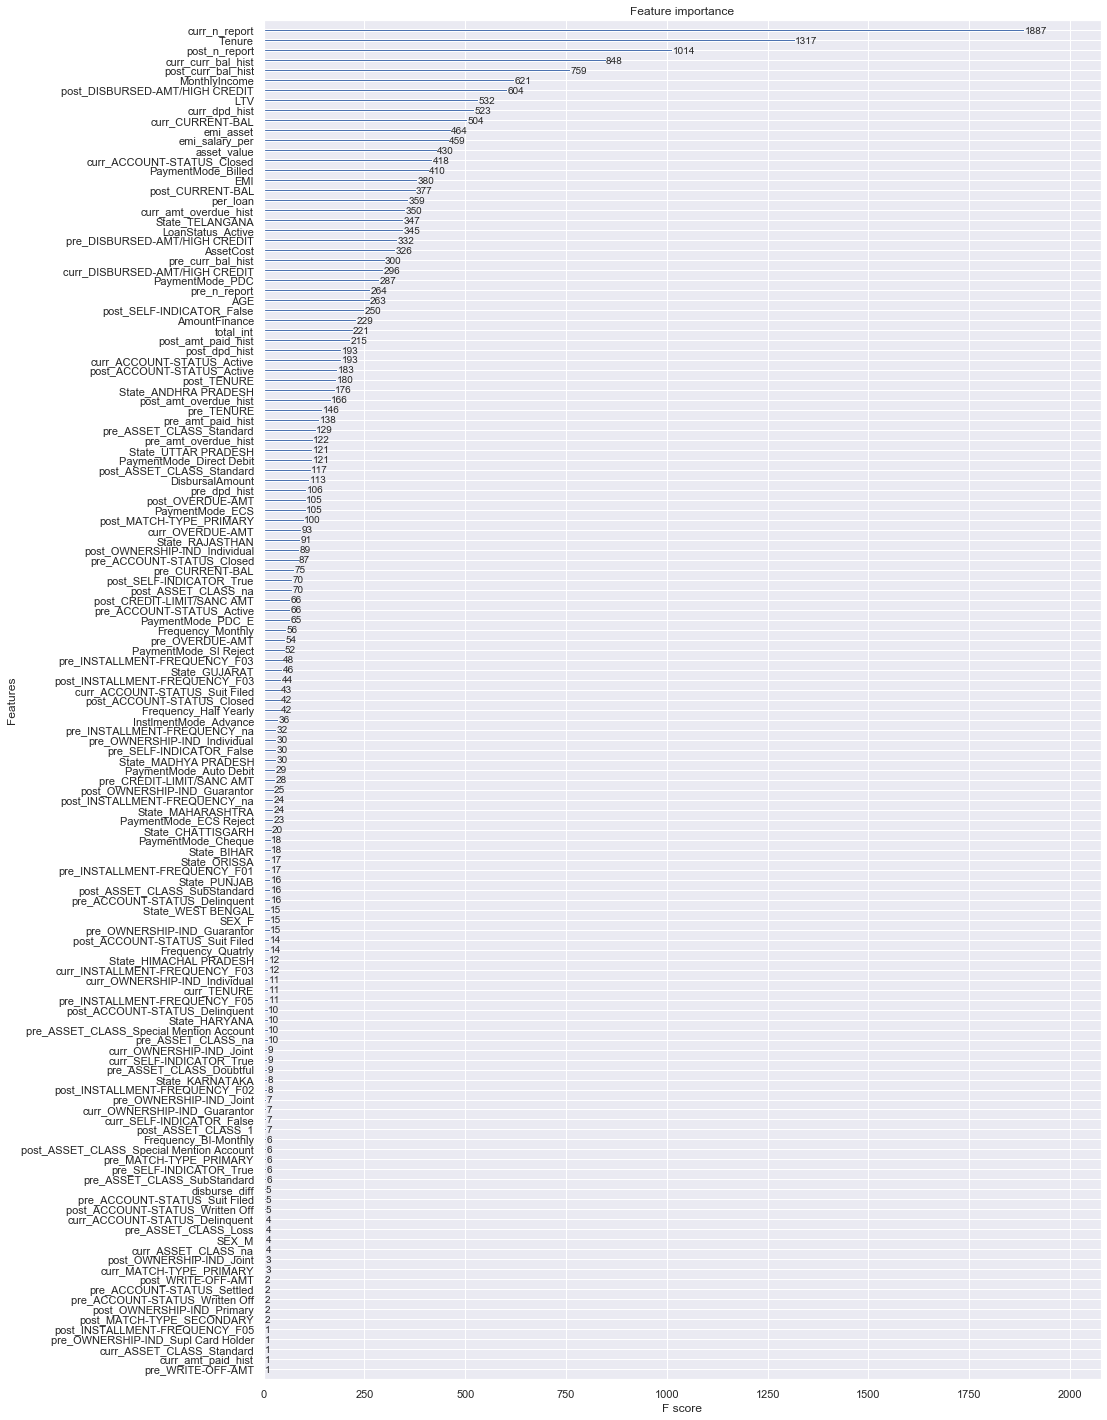

In [26]:
plt.rcParams["figure.figsize"] = (15, 25)
plot_importance(xgb)